In [1]:
import os
import random
from pathlib import Path


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
device = torch.device("cuda")  

torch.cuda.memory_allocated(device)   # bytes allocated by tensors
torch.cuda.memory_reserved(device)    # bytes reserved by allocator
torch.cuda.empty_cache()              # frees cached memory (non-deterministic improvement)

print("python:", os.sys.version.splitlines()[0])
print("torch:", torch.__version__)
print(torch.cuda.get_device_name())

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

python: 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]
torch: 2.6.0+cu124
Tesla V100-SXM2-32GB


In [3]:
BANANA_ORIG_ROOT = Path('./data/BananaLSD/OriginalSet') # point to the directory containing original banana images
CORN_ROOT = Path('./data/CornLSD') # point to corn dataset root (class subfolders)


print('Banana original folder exists:', BANANA_ORIG_ROOT.exists())
print('Corn root exists:', CORN_ROOT.exists())

Banana original folder exists: True
Corn root exists: True


In [4]:
def list_subfolders(root: Path, max_print=10):
    if not root.exists():
        return []
    folders = [p for p in sorted(root.iterdir()) if p.is_dir()]
    for i, f in enumerate(folders[:max_print]):
        print(f"{i+1}. {f.name} (contains {len(list(f.glob('**/*.*')))} files)")
    return folders

In [5]:
print('\nBanana classes/folders:')
list_subfolders(BANANA_ORIG_ROOT)
print('\nCorn classes/folders:')
list_subfolders(CORN_ROOT)


Banana classes/folders:
1. cordana (contains 162 files)
2. healthy (contains 129 files)
3. pestalotiopsis (contains 173 files)
4. sigatoka (contains 473 files)

Corn classes/folders:
1. Blight (contains 1146 files)
2. Common_Rust (contains 1306 files)
3. Gray_Leaf_Spot (contains 574 files)
4. Healthy (contains 1162 files)


[PosixPath('data/CornLSD/Blight'),
 PosixPath('data/CornLSD/Common_Rust'),
 PosixPath('data/CornLSD/Gray_Leaf_Spot'),
 PosixPath('data/CornLSD/Healthy')]

In [6]:
class TwoDatasetImages(Dataset):
    """Dataset combining banana (original-only) and corn images.

    Each sample: (image_tensor, metadata_dict)
    metadata_dict contains: source ('banana' or 'corn'), orig_class (string), path (string)
    """

    def __init__(self, banana_root: Path, corn_root: Path, transform=None, extensions=('.jpg', '.jpeg', '.png')):
        self.samples = []
        self.transform = transform
        self.extensions = extensions

        # Banana: look one level deeper for class folders
        if banana_root.exists():
            for cls_dir in sorted([p for p in banana_root.iterdir() if p.is_dir()]):
                for img_path in cls_dir.glob('*'):
                    if img_path.suffix.lower() in self.extensions:
                        self.samples.append((str(img_path), 'banana', cls_dir.name))

        # Corn: assume corn_root has class subfolders
        if corn_root.exists():
            for cls_dir in sorted([p for p in corn_root.iterdir() if p.is_dir()]):
                for img_path in cls_dir.glob('*'):
                    if img_path.suffix.lower() in self.extensions:
                        self.samples.append((str(img_path), 'corn', cls_dir.name))

        if len(self.samples) == 0:
            print('Warning: no samples found. Check paths and folder structure.')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, source, orig_class = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = T.ToTensor()(img)
        metadata = {'source': source, 'orig_class': orig_class, 'path': path}
        return img_t, metadata

In [7]:
IMAGE_SIZE = 224
batch_size = 64
num_workers = 4

transform_vis = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset=TwoDatasetImages(BANANA_ORIG_ROOT,CORN_ROOT,transform=transform_vis)
print('Total samples found (banana + corn) : ',len(dataset))
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

Total samples found (banana + corn) :  5125


In [8]:
from collections import Counter
sources = [m[1] for m in dataset.samples]
print('Counts by source:', Counter(sources))

Counts by source: Counter({'corn': 4188, 'banana': 937})


In [9]:
def denormalize(tensor_img):
    """Assumes tensor_img is CxHxW normalized with ImageNet mean/std; returns numpy HxWxC in [0,1]"""
    mean = np.array([0.485, 0.456, 0.406])[:, None, None]
    std = np.array([0.229, 0.224, 0.225])[:, None, None]
    img = tensor_img.cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    return img

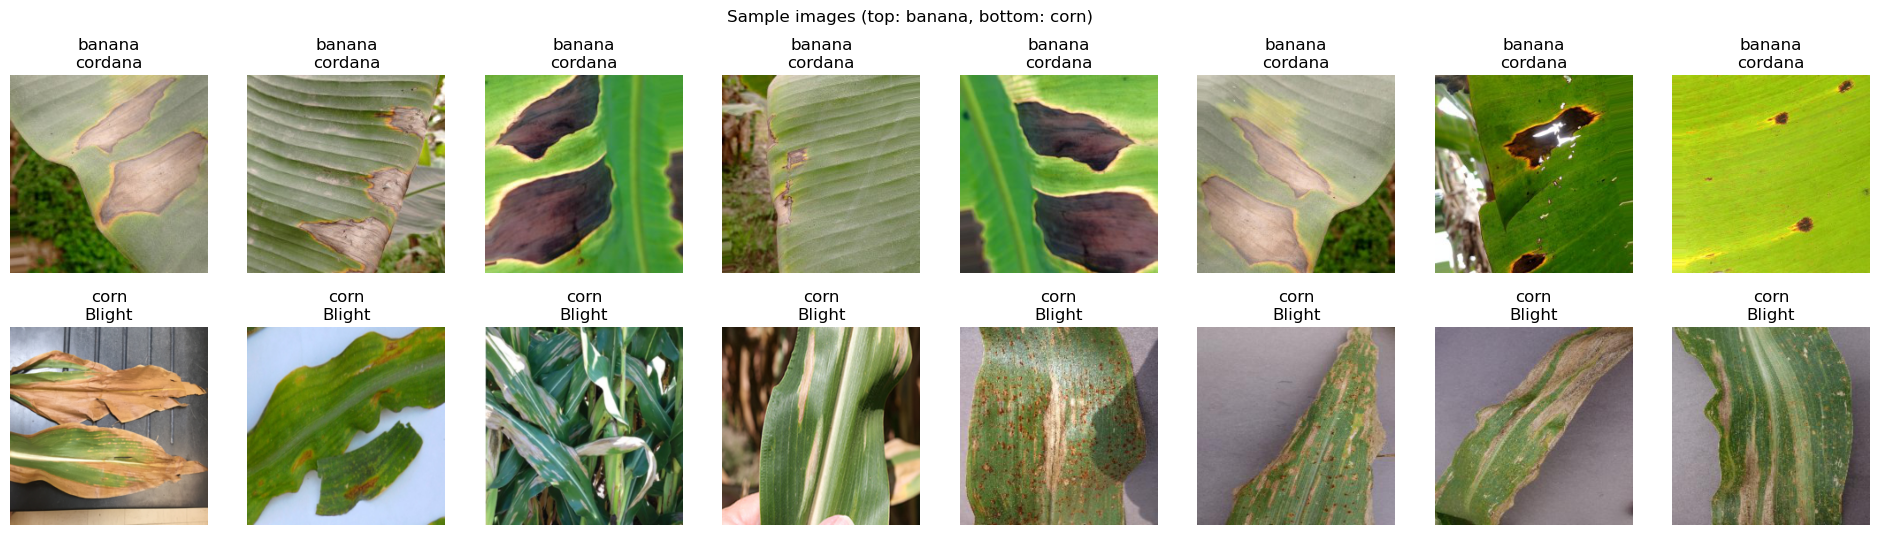

In [10]:
N = 8
banana_imgs = [ (i,p) for i,(p) in enumerate(dataset.samples) if p[1]=='banana'][:N]
corn_imgs = [ (i,p) for i,(p) in enumerate(dataset.samples) if p[1]=='corn'][:N]

fig, axes = plt.subplots(2, N, figsize=(3*N, 6))
for j, (idx, meta) in enumerate(banana_imgs):
    img, md = dataset[idx]
    axes[0, j].imshow(denormalize(img))
    axes[0, j].axis('off')
    axes[0, j].set_title(f"banana\n{md['orig_class']}")

for j, (idx, meta) in enumerate(corn_imgs):
    img, md = dataset[idx]
    axes[1, j].imshow(denormalize(img))
    axes[1, j].axis('off')
    axes[1, j].set_title(f"corn\n{md['orig_class']}")

plt.suptitle('Sample images (top: banana, bottom: corn)')
plt.show()


In [11]:
import torch.nn as nn

# Choose backbone: EfficientNet-B0
use_backbone = 'efficientnet_b0'  # change if you prefer resnet50 or resnet101

if use_backbone.startswith('efficientnet'):
    try:
        # Newer torchvision: use weights API
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        backbone_model = models.efficientnet_b0(weights=weights)
    except Exception:
        # Fallback for older torchvision
        backbone_model = models.efficientnet_b0(pretrained=True)
    # Build feature extractor: features -> adaptive pool -> flatten
    class EfficientNetFeatureExtractor(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.features = model.features
            self.pool = nn.AdaptiveAvgPool2d(1)
            self.flatten = nn.Flatten()

        def forward(self, x):
            x = self.features(x)
            x = self.pool(x)
            x = self.flatten(x)
            return x

    feature_extractor = EfficientNetFeatureExtractor(backbone_model)
    feat_dim = 1280

else:
    # fallback to ResNet50 feature extractor
    try:
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        resnet = models.resnet50(weights=weights)
    except Exception:
        resnet = models.resnet50(pretrained=True)
    # Remove the final fc and use avgpool output
    class ResNetFeatureExtractor(nn.Module):
        def __init__(self, model):
            super().__init__()
            # everything except the final fc
            self.backbone = nn.Sequential(*(list(model.children())[:-1]))
        def forward(self, x):
            x = self.backbone(x)
            x = torch.flatten(x, 1)
            return x
    feature_extractor = ResNetFeatureExtractor(resnet)
    feat_dim = 2048

feature_extractor.to(device)
feature_extractor.eval()

# We'll run inference with torch.no_grad()

print('Feature extractor ready. Feature dim =', feat_dim)

Feature extractor ready. Feature dim = 1280


In [12]:
import tqdm

n_samples = len(dataset)
embeddings = np.zeros((n_samples, feat_dim), dtype=np.float32)
meta_list = []

idx = 0
with torch.no_grad():
    for batch_imgs, batch_meta in tqdm.tqdm(dataloader, desc='Extracting embeddings'):
        batch_size_curr = batch_imgs.size(0)
        batch_imgs = batch_imgs.to(device)
        feats = feature_extractor(batch_imgs)
        feats = feats.cpu().numpy()
        embeddings[idx: idx + batch_size_curr] = feats
        # store metadata
        for m in batch_meta:
            meta_list.append(m)
        idx += batch_size_curr

print('Extracted embeddings shape:', embeddings.shape)

Extracting embeddings:   6%|███▊                                                         | 5/81 [00:02<00:21,  3.48it/s]/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
Extracting embeddings:  15%|████████▉                                                   | 12/81 [00:05<00:20,  3.36it/s]/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Extracting embeddings:  16%|█████████▋                                                  | 13/81 [00:05<00:23,  2.95it/s]/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/PIL/JpegImagePlugin.py:887: UserWarning: Image appears to be a malforme

Extracted embeddings shape: (5125, 1280)


In [13]:
out_dir = Path('./outputs')
out_dir.mkdir(exist_ok=True)
np.save(out_dir / 'embeddings.npy', embeddings)

import csv
meta_csv = out_dir / 'metadata.csv'

if len(meta_list) == 0:
    raise RuntimeError('meta_list is empty — something went wrong during extraction')

# Detect whether meta_list contains dicts
if isinstance(meta_list[0], dict):
    canonical_meta = meta_list
else:
    # Fallback: rebuild canonical_meta from dataset.samples (which we populated reliably in __init__)
    canonical_meta = []
    for path, source, orig_class in dataset.samples:
        canonical_meta.append({'source': source, 'orig_class': orig_class, 'path': path})

with open(meta_csv, 'w', newline='', encoding='utf-8') as f:
    writer = csv.DictWriter(f, fieldnames=['index', 'source', 'orig_class', 'path'])
    writer.writeheader()
    for i, md in enumerate(canonical_meta):
        writer.writerow({'index': i, 'source': md['source'], 'orig_class': md['orig_class'], 'path': md['path']})

print('Saved embeddings and metadata in', out_dir)


Saved embeddings and metadata in outputs


In [14]:
from umap import UMAP
from sklearn.decomposition import PCA

pca_n = 50
pca = PCA(n_components=pca_n, random_state=seed)
emb_pca = pca.fit_transform(embeddings)
print('PCA completed. Shape:', emb_pca.shape)

# UMAP (unsupervised)
umap_reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=seed)
emb_umap = umap_reducer.fit_transform(emb_pca)
print('UMAP (unsupervised) done. Shape:', emb_umap.shape)


PCA completed. Shape: (5125, 50)


/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP (unsupervised) done. Shape: (5125, 2)


In [15]:
# t-SNE (unsupervised)
# t-SNE can be slow. Use init='pca' for better convergence.
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=seed,method='barnes_hut', max_iter=250)
emb_tsne = tsne.fit_transform(emb_pca)
print('t-SNE done. Shape:', emb_tsne.shape)

# Save embeddings
np.save(out_dir / 'emb_pca50.npy', emb_pca)
np.save(out_dir / 'emb_umap.npy', emb_umap)
np.save(out_dir / 'emb_tsne.npy', emb_tsne)

t-SNE done. Shape: (5125, 2)


In [16]:
import pandas as pd
meta_df = pd.DataFrame(canonical_meta)
meta_df.insert(0, 'index', np.arange(len(meta_df)))
meta_df.to_csv(out_dir / 'metadata.csv', index=False)
print('Saved embeddings and metadata to', out_dir)

Saved embeddings and metadata to outputs


In [17]:
orig_classes = list(meta_df['orig_class'])
unique_classes = sorted(list(set(orig_classes)))
class_to_idx = {c: i for i, c in enumerate(unique_classes)}
labels = np.array([class_to_idx[c] for c in orig_classes])

sup_umap = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=seed)
emb_sup_umap = sup_umap.fit_transform(emb_pca, y=labels)
np.save(out_dir / 'emb_sup_umap.npy', emb_sup_umap)
print('Supervised UMAP done:', emb_sup_umap.shape)

/home/23ucc611/miniconda3/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Supervised UMAP done: (5125, 2)


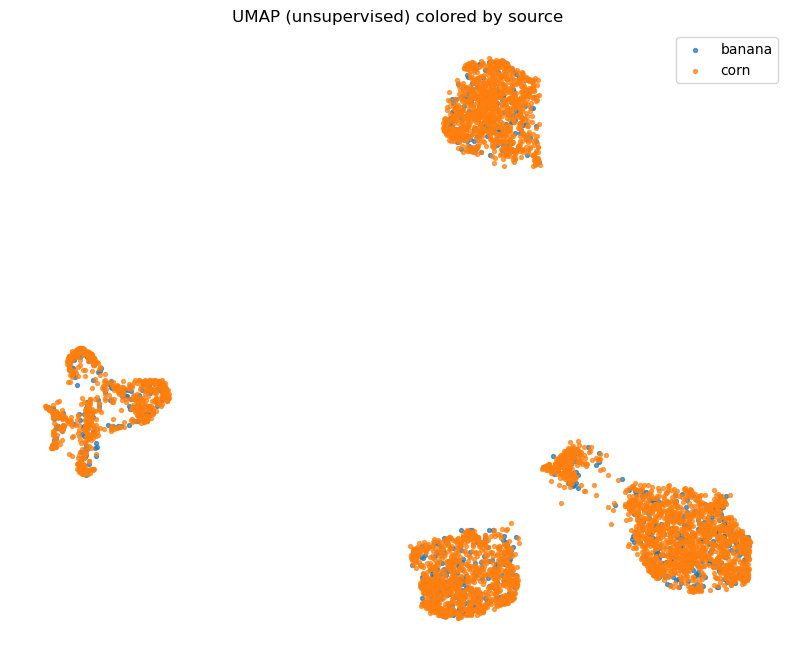

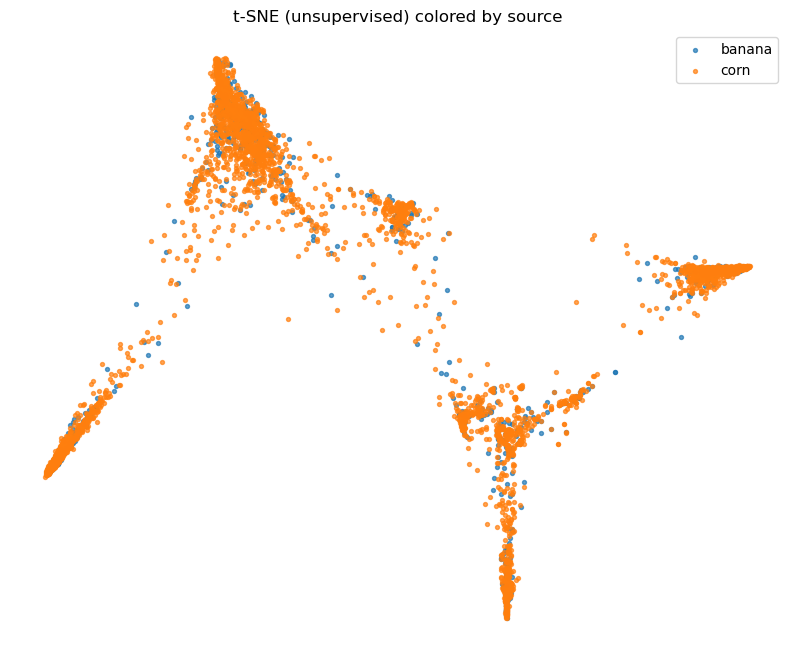

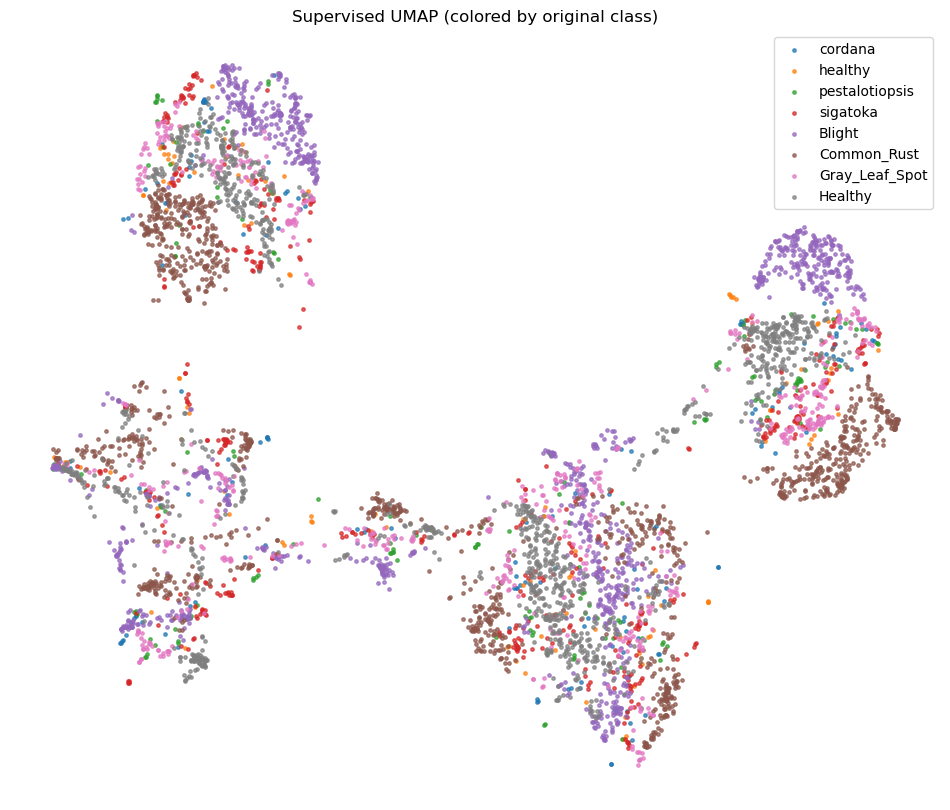

In [18]:
orig_classes = list(meta_df['orig_class'])

import matplotlib

plot_df = meta_df.copy()
plot_df['source'] = plot_df['source'].astype(str)
plot_df['orig_class'] = plot_df['orig_class'].astype(str)

def plot_2d(points, df, color_col='source', title='2D projection', figsize=(10,8), s=8, savepath=None):
    fig, ax = plt.subplots(figsize=figsize)
    uniq = df[color_col].unique()
    for val in uniq:
        mask = df[color_col] == val
        ax.scatter(points[mask,0], points[mask,1], s=s, label=str(val), alpha=0.7)
    ax.legend()
    ax.set_title(title)
    ax.axis('off')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=200)
    plt.show()

# UMAP unsupervised colored by source
plot_2d(emb_umap, plot_df, color_col='source', title='UMAP (unsupervised) colored by source', savepath=out_dir/'umap_by_source.png')

# t-SNE unsupervised colored by source
plot_2d(emb_tsne, plot_df, color_col='source', title='t-SNE (unsupervised) colored by source', savepath=out_dir/'tsne_by_source.png')

# Supervised UMAP colored by original class
plot_2d(emb_sup_umap, plot_df, color_col='orig_class', title='Supervised UMAP (colored by original class)', figsize=(12,10), s=6, savepath=out_dir/'sup_umap_by_class.png')